In [1]:
!pip install wordcloud

In [2]:
!pip install regex

In [3]:
# Import libraries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix

from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import regex as re

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Content

- [Data Cleaning/Preprocessing and Exploration](#Data-Cleaning/Preprocessing-and-Exploration)
- [Modelling](#Modelling)
    - [Naive Bayes](#Multi-nomial-Naive-bayes-model)
    - [Logistic Regression](#Logistic-regression-model)
- [Model selection and Prediction](#Model-Prediction-on-test-dataset)
- [Conclusion](#Conclusion)

# Data Cleaning/Preprocessing and Exploration

In [4]:
df1 = pd.read_csv('./datasets/HFY.csv')
df2 = pd.read_csv('./datasets/nosleep.csv')

In [5]:
# 'title' column is the title of the subreddit post
# 'selftext' column is the content of the post
# 'subreddit' column is where the post is from
# 'selftext' will be the X variable, whilst 'subreddit' will be used to create the y variable
post1 = df1[['title', 'selftext', 'subreddit']]
post2 = df2[['title', 'selftext', 'subreddit']]

In [6]:
# Create a single dataframe from appending post2 to post1, call it posts
posts = post1.append(post2)
posts.reset_index(drop=True, inplace=True)

In [7]:
# Check the number of posts from each subreddit
posts['subreddit'].value_counts()

HFY        1004
nosleep     990
Name: subreddit, dtype: int64

- The number of posts gained from both subreddits are pretty balanced and in the expected range of posts.

In [8]:
# Check for any null values in the posts
posts.isnull().sum()

title         0
selftext     13
subreddit     0
dtype: int64

- There are 13 posts with NaN values.

In [9]:
# Calculate percentage of NaN values in terms of total number of entries for posts
(13/1994)*100

0.6519558676028084

In [10]:
# Check which subreddits the NaN posts are from
posts[posts['selftext'].isnull() == True]

,title,selftext,subreddit
190,I'm a bit confused by this sub. I know its sta...,NaN,HFY
195,LFS Looking for stories about a man and his do...,NaN,HFY
379,Battleship (2012) is pretty godamn HFY,NaN,HFY
743,Stories where only humans have fictional world...,NaN,HFY
755,[Meta] Any stories that are about human kindne...,NaN,HFY
784,"Just read True Human Rage, and that other depr...",NaN,HFY
805,Where's the writing prompt contest?,NaN,HFY
824,[LFS] Stories where spacefaring OC crash lands...,NaN,HFY
1004,Spooktober! 31 Days of Horror Nosleep Event,NaN,nosleep
1005,August 2019 Voting Thread,NaN,nosleep


- Since the number of posts that are null values is relatively low, only 0.65% of the total number of posts
- And there seems to be a roughly equivalent amount of null values from each subreddit
- And also because a guess at the content of the post would not be reasonably accurate
- It is judged to be acceptable to just drop the rows

In [11]:
# Drop rows with NaN 
posts.dropna(inplace=True)

In [12]:
# Re-check the number of posts from each subreddit
posts['subreddit'].value_counts()

HFY        996
nosleep    985
Name: subreddit, dtype: int64

- The amount of posts is still roughly the same.

In [13]:
# Check for duplicates and see the distribution of duplicate posts across the 2 subreddits
posts[posts['selftext'].duplicated()]['subreddit'].value_counts()

HFY        177
nosleep    176
Name: subreddit, dtype: int64

- There seems to be quite a large amount of duplicates
- This is because the subreddits (at the time of scraping), had less than 1000 posts. Hitting the reddit API after the last post had been scraped caused the API to start since the beginning again.

In [14]:
# Drop the duplicate posts
# Pretty much the same number of posts will be dropped
# After dropping, there will still be enough posts to use for classification
posts.drop_duplicates(subset='selftext', inplace=True)

In [15]:
posts['subreddit'].value_counts()

HFY        819
nosleep    809
Name: subreddit, dtype: int64

- There is still a sufficiently large number of posts in which to use for modelling.

In [16]:
# Create target column
# 0 is r/HFY, 1 is r/nosleep
posts['nosleep'] = posts['subreddit'].map(lambda x: 1 if x == 'nosleep' else 0)

In [17]:
posts.head()

,title,selftext,subreddit,nosleep
0,End Of Month September 2019,Well the old homestead was a nice place till w...,HFY,0
1,October MWC: [Hallows 6] Update 1!,Did you hear that!?!?! I think it was the soun...,HFY,0
2,The Lies of Humanity,"“Humans are a race of liars,” Tsah slurred lou...",HFY,0
3,Supervillainy and Other Poor Career Choices - ...,\n\n“You sold our friend into slavery!?”\n\nE...,HFY,0
4,[PI] The first alien transmission Earth receiv...,In the year 2025 mankind had intercepted the f...,HFY,0


In [18]:
# Split the posts dataset into a train and test dataset
# The test dataset will be untouched until the model is used to make predictions.
train, test = train_test_split(posts, test_size=0.25, random_state=55, stratify = posts['nosleep'])

In [19]:
train.shape

(1221, 4)

In [20]:
test.shape

(407, 4)

In [21]:
# Create X and y variables
# It was decided that the title would not be used as a predictor variable as some titles are dead giveaways for the subreddit
X = train['selftext']
y = train['nosleep']

In [22]:
# Create training and testing sets from the train dataset
X_training, X_testing, y_training, y_testing = train_test_split(X, y, stratify=y, test_size=0.25, random_state=55)

In [23]:
# Reset the index of each dataframe
X_training.reset_index(drop=True, inplace=True)
X_testing.reset_index(drop=True, inplace=True)
y_training.reset_index(drop=True, inplace=True)
y_testing.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [24]:
print(stop_words.ENGLISH_STOP_WORDS)

frozenset({'fifty', 'yourselves', 'as', 'few', 'around', 'must', 'was', 'sometimes', 'back', 'last', 'do', 'seem', 'never', 'hereafter', 'these', 'any', 'the', 'why', 'anyhow', 'fifteen', 'nobody', 'three', 'will', 'over', 're', 'whatever', 'please', 'move', 'who', 'am', 'before', 'six', 'whole', 'whoever', 'whenever', 'at', 'could', 'both', 'because', 'has', 'if', 'twenty', 'under', 'nine', 'system', 'same', 'while', 'either', 'yet', 'where', 'hence', 'than', 'an', 'two', 'me', 'to', 'above', 'other', 'this', 'whether', 'nor', 'describe', 'so', 'then', 'most', 'full', 'least', 'that', 'by', 'neither', 'his', 'what', 'behind', 'your', 'therein', 'towards', 'nothing', 'hereupon', 'beforehand', 'everyone', 'ourselves', 'rather', 'now', 'get', 'whereas', 'across', 'whereupon', 'itself', 'is', 'found', 'might', 'amoungst', 'be', 'those', 'seeming', 'co', 'would', 'with', 'take', 'along', 'empty', 'onto', 'became', 'show', 'eleven', 'whereby', 'less', 'up', 'although', 'interest', 'therefor

In [25]:
# Define a fn to clean individual posts 
def clean_post(post):
    post_txt = BeautifulSoup(post).get_text()
    # Define regex pattern to replace all 'r/' (indicating the subreddit), urls, 
    # any non-alphabet characters, and any words giving away the subreddit (hfy/nosleep), with a space
    letters_only = re.sub("(r\/)|((https:\/\/|http:\/\/|www.)[\w.\/\?\=\w]*)|[^a-zA-Z]|(hfy|nosleep)", " ", post_txt)
    
    # Tokenize the post, return individual words as a list
    words = letters_only.lower().split()
    
    # remove stopwords
    stops = set(stop_words.ENGLISH_STOP_WORDS)
    meaningful_words = [word for word in words if word not in stops]
    
    # Lemmatize the words in the token list
    # Lemmatization chosen over stemming as short stories may use wider variety of words which stemming might incorrectly overstem
    # Thus, a lot of information would be lost
    lemmatizer = WordNetLemmatizer()
    lem_words = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # join the meaningful words
    cleaned_post = " ".join(lem_words)
    
    return cleaned_post


In [26]:
# Define a fn which will call the fn clean_post() for all posts in the dataframe
def cleaned_posts(X = X_training):
    cleaned_posts = []
    for i, v in enumerate(X):
        cleaned_posts.append(clean_post(X[i]))
    
    return cleaned_posts

In [27]:
X_training_cleaned = cleaned_posts(X_training)
print(f'There are {len(X_training_cleaned)} posts in X_training_cleaned')

There are 915 posts in X_training_cleaned


In [28]:
# Check first 5 posts from X_training_cleaned
X_training_cleaned[0:5]

['asked mama care smiled love love wasn t thunderstorm erased stupid wall painting bent basketball hoop torn net rusted saw left small playground sat amidst cracked tile small hall used lay mattress seventeen singing song just sipping warm bowl soup huddled mama s story saw mama frail forth favorite chair realized time take nia new baby cry sheet wet sweat couldn t roll lift head fuck s sake mama heard cry started chorus scream chipped wooden crib mama heard got auburn way running stomach swollen cradled nia arm rocking gently jon mind whispered went kitchen cold milk hungry m worried mama said plopped yellow rubbered bottle tiny lip shouting gradually died auburn said check did check mama said fine tear said headstrong tried pry wrong said sorry couldn t baby heard ankle hurting bad spine starting curl just night know said carried bed said d okay sun come underneath eyelid persistent glimmer life spark believe d hold forever oliver screamed distance hurried buried trove rusted toy car

- *It appears some words have been quite badly butchered to the point of being unrecognizable, but in general there seems to be enough meaningful words to proceed with EDA and modelling.*

In [29]:
X_testing_cleaned = cleaned_posts(X_testing)
print(f'There are {len(X_testing_cleaned)} posts in X_testing_cleaned')

There are 306 posts in X_testing_cleaned


In [30]:
# Generate a list of posts from r/nosleep
nosleep_posts = []
for i in y_training[y_training == 1].index: # Get index of y_training where the value == 1, meaning that the post is from r/nosleep
    nosleep_posts.append(X_training_cleaned[i]) # Append the corresponding post to nosleep_posts

In [31]:
# Generate a list of posts from r/HFY
hfy_posts = []
for i in y_training[y_training == 0].index: # Get index of y_training where the value == 0, meaning that the post is from r/HFY
    hfy_posts.append(X_training_cleaned[i]) # Append the corresponding post to nosleep_posts

In [32]:
print(f'In X_training_cleaned, there are {len(nosleep_posts)} posts from r/nosleep')

In X_training_cleaned, there are 455 posts from r/nosleep


In [33]:
print(f'In X_training_cleaned, there are {len(hfy_posts)} posts from r/HFY')

In X_training_cleaned, there are 460 posts from r/HFY


- *There are a similar number of posts in X_training_cleaned*

## Exploration of post lengths (after cleaning)

In [34]:
# Create an empty list to append the length of each individual post for r/nosleep
len_nosleep_posts = []
for i in nosleep_posts:
    len_nosleep_posts.append(len(i.split(' ')))# Split using ' ' delimiter to create list of words, so can count no. of words

In [35]:
# Create an empty list to append the length of each individual post for r/HFY
len_hfy_posts = []
for i in hfy_posts:
    len_hfy_posts.append(len(i.split(' ')))# Split using ' ' delimiter to create list of words, so can count no. of words

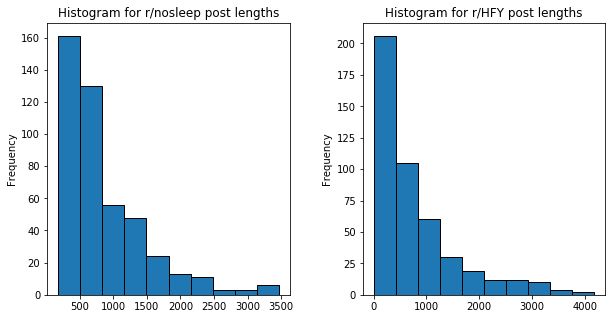

In [36]:
# Plot histograms of the distribution of post lengths (w/ only meaningful words) for the 2 subreddits
plt.rcParams["patch.force_edgecolor"] = True
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=False)
plt.subplots_adjust(wspace=0.3)
ax = ax.ravel()
ax0 = pd.Series(len_nosleep_posts).plot(kind='hist', ax=ax[0])
ax0.title.set_text('Histogram for r/nosleep post lengths')
ax1 = pd.Series(len_hfy_posts).plot(kind='hist', ax=ax[1])
ax1.title.set_text('Histogram for r/HFY post lengths')

- Overall, the distributions are both positively skewed.
    - *It can be inferred that*:
        - Generally there is higher probability for a post length to be shorter compared to longer (assuming any length threshold)
        - The actual average post length (with no stop words/characters removed), is greater for r/nosleep vs r/HFY.
    - *It is assumed that*:
        - The amount of stopwords in each individual post, across both corpuses, is roughly the same. If it is a random distribution then this could affect the distribution of post lengths derived from only meaningful words.
- r/HFY in general seems to have shorter post lengths with meaningful words compared to r/nosleep, either suggesting a higher usage of stop words, or that posters to r/HFY typically write shorter posts. 

## Exploration of words

### Using Count Vectorization

In [37]:
# Initialize count vectorizer
cvec = CountVectorizer(min_df=10, max_df=0.95) # set min_df=10 and max_df=0.95

In [38]:
# Create a dataframe derived from the count vectorization of the posts from r/nosleep
cvec_df_nosleep = pd.DataFrame(cvec.fit_transform(pd.Series(nosleep_posts)).toarray(), 
                       columns=cvec.get_feature_names())

In [39]:
# Create a dataframe derived from the count vectorization of the posts from r/nosleep
cvec_df_hfy = pd.DataFrame(cvec.fit_transform(pd.Series(hfy_posts)).toarray(), 
                       columns=cvec.get_feature_names())

#### Comparison of top 15 most used words from the 2 subreddits

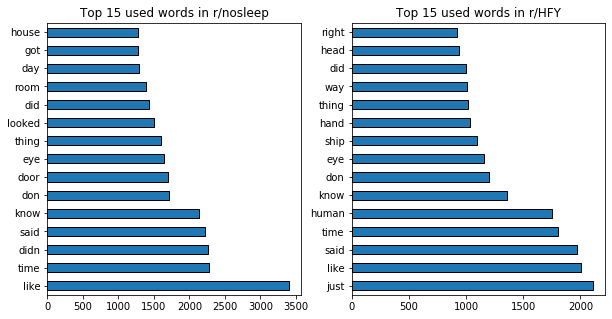

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=False)
ax = ax.ravel()
cvec_df_nosleep.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[0], title='Top 15 used words in r/nosleep')
cvec_df_hfy.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[1], title='Top 15 used words in r/HFY')

- The top 15 used words are quite similar between the 2 subreddits, however there are differences as well.
- The magnitude of the times a specific word is used is greater in r/nosleep compared to r/HFY.
- The top used word ('like') in r/nosleep has a distinct lead over other top 15 words, whereas the top used word ('just') in r/HFY does not have such a distinct lead.

In [41]:
# Get the top 15 words in both subreddits as a list
top15_nosleep_lst = cvec_df_nosleep.sum().sort_values(ascending=False).head(15).keys()
top15_hfy_lst = cvec_df_hfy.sum().sort_values(ascending=False).head(15).keys()

# Convert the lists of words into sets and find the intersection
print("The following set of words are in both subreddits' top 15 most used words:")
print(set(top15_nosleep_lst).intersection(set(top15_hfy_lst)))
print('')
print("The following set of words are in either (but not both) subreddits' top 15 most used words:")
print(set(top15_nosleep_lst).symmetric_difference(set(top15_hfy_lst)))

The following set of words are in both subreddits' top 15 most used words:
{'like', 'eye', 'time', 'thing', 'know', 'don', 'did', 'said'}

The following set of words are in either (but not both) subreddits' top 15 most used words:
{'right', 'ship', 'got', 'head', 'door', 'looked', 'human', 'room', 'house', 'hand', 'day', 'just', 'didn', 'way'}


- Overall, there are 10 words in the intersection between the 2 sets of top 15 words.
- 'time' seems to be quite a popular word to use across the 2 subreddits, and relatively equal in popularity (used approx. 2000 times)
- 'thing', 'eye', 'hand', 'way' also seem to be relatively similar in terms of times used.
- Even though there are a lot of overlaps between commonly used words, there appears to be words which can be used to provide distinction between the 2 subreddits.

#### Aggregating between the 2 subreddits

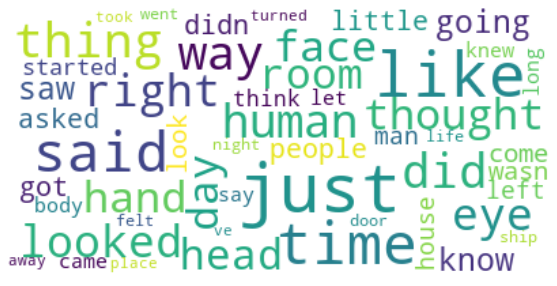

In [42]:
# Create a word cloud to visualize the commonly used words across the 2 subreddits
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white",
                      stopwords=stop_words.ENGLISH_STOP_WORDS).generate(" ".join(X_training_cleaned))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [43]:
# Make a dataframe of the count of all words across the 2 subreddits
cvec = CountVectorizer(min_df=10, max_df=0.95) # set min_df=10 and max_df=0.95
cvec_df = pd.DataFrame(cvec.fit_transform(pd.Series(X_training_cleaned)).toarray(), 
                       columns=cvec.get_feature_names())
# Filter out the stopwords used in the wordcloud
cvec_df = cvec_df[[col for col in cvec_df.columns if col not in wordcloud.stopwords]]

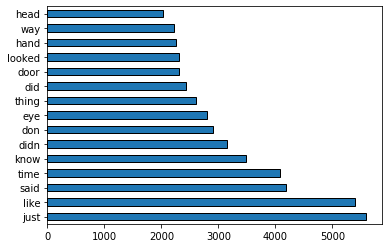

In [44]:
# Plot out the 15 most used words across both subreddits
cvec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')

- Across the 2 subreddits, 'just' is the most commonly used word.
- The top few words from the above plot are popular words in both subreddits. (i.e. 'just' and 'like' are popular words in both subreddits)
    - 'human', a top 15 used word in r/HFY but not in r/nosleep, is ranked 15th
    - 'looked', a top 15 used word in r/nosleep but not in r/HFY, is ranked 10th

In [45]:
# count vectorization using hyperparameters: min_df=10, max_df=0.95
# print out the number of unique words in X_training_cleaned after count vectorization
print(f'The number of unique words obtained after applying count vectorization on X_training_cleaned: {cvec_df.shape[1]}')

The number of unique words obtained after applying count vectorization on X_training_cleaned: 6427


- *There seems to be enough meaningful words in the corpus in order to construct a model that can perform acceptably well.*

### Using tf-idf

- Using the same procedure as count vectorization, the top 15 most common words will be explored.

In [46]:
# Initialize TfidfVectorizer
tvec = TfidfVectorizer(min_df=10, max_df=0.95) # set min_df=10 and max_df=0.95

In [47]:
# Create a dataframe derived from the count vectorization of the posts from r/nosleep
tvec_df_nosleep = pd.DataFrame(tvec.fit_transform(pd.Series(nosleep_posts)).toarray(), 
                       columns=tvec.get_feature_names())

In [48]:
# Create a dataframe derived from the count vectorization of the posts from r/HFY
tvec_df_hfy = pd.DataFrame(tvec.fit_transform(pd.Series(hfy_posts)).toarray(), 
                       columns=tvec.get_feature_names())

#### Comparison of top 15 most used words from the 2 subreddits

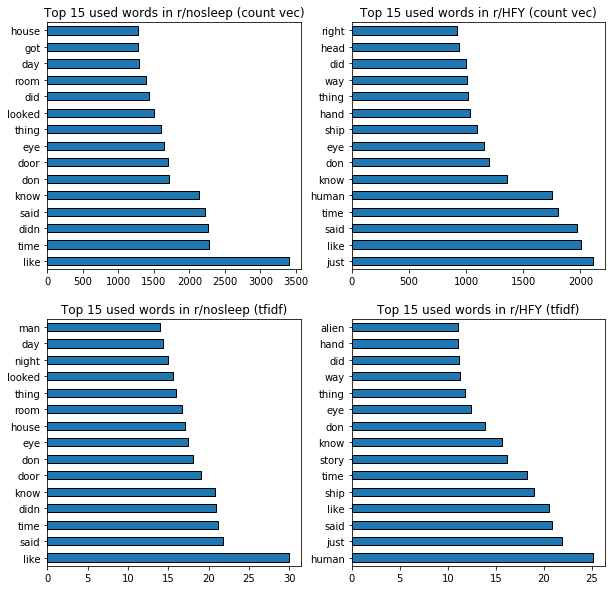

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharex=False)
ax = ax.ravel()
cvec_df_nosleep.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[0], title='Top 15 used words in r/nosleep (count vec)')
cvec_df_hfy.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[1], title='Top 15 used words in r/HFY (count vec)')
tvec_df_nosleep.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[2], title='Top 15 used words in r/nosleep (tfidf)')
tvec_df_hfy.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[3], title='Top 15 used words in r/HFY (tfidf)')

- Using tfidf, the effect of penalizing words generally used throughout the corpus can be seen.
    - e.g., in r/HFY after using tf-idf, 'human' has the highest weightage now instead of 'just'. This shows that 'human' is used often in certain posts, but appear in less posts as compared to 'just'.

#### Aggregating between the 2 subreddits

In [50]:
# Make a dataframe of the count of all words across the 2 subreddits
tvec_df = pd.DataFrame(tvec.fit_transform(pd.Series(X_training_cleaned)).toarray(), 
                       columns=tvec.get_feature_names())
# Filter out the stopwords used in the wordcloud
tvec_df = tvec_df[[col for col in tvec_df.columns if col not in wordcloud.stopwords]]

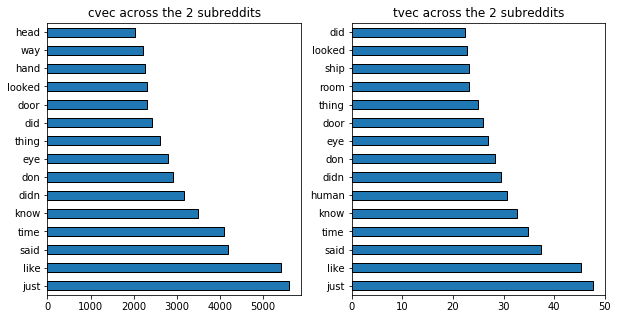

In [51]:
# Plot out the 15 most used words across both subreddits
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=False)
ax = ax.ravel()
cvec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[0], title='cvec across the 2 subreddits')
tvec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[1], title='tvec across the 2 subreddits')

- 'human' increased quite significantly in terms of weightage after using tf-idf
- Some words which were not in the top 15 used words using count vectorization, appeared after using tf-idf
    - 'room', 'story', and 'house' appeared after using tf-idf

In [52]:
# tf-idf vectorization using hyperparameters: min_df=10, max_df=0.95
# print out the number of unique words in X_training_cleaned after tf-idf vectorization
print(f'The number of unique words obtained after applying tf-idf vectorization on X_training_cleaned: {tvec_df.shape[1]}')

The number of unique words obtained after applying tf-idf vectorization on X_training_cleaned: 6427


# Modelling

- Naive-bayes and Logistic Regression were chosen as the 2 models to use.
- They are similar in the sense that both are common models used for binary classification problems.
- The differences between them lie in the fact that:
    - Naive-bayes: The weightage for each feature (word) is set independently, depending on the degree of correlation to the class. It assumes independence between each word, when that might not be the case. E.g.: 
        - 2 words appear quite frequently throughout a corpus, but 
        - they are in reality, highly correlated words with each other (i.e. using word 'a' will typically be followed with word 'b')
        - a naive bayes model will give equal weightage for these 2 words
    - Logistic regression: The weightage for each feature is set simultaneously, and along with a regularization technique, words with multicollinearity with each other will be penalized to a certain extent. 
    - Naive Bayes models reach the asymptotic solution faster than Logistic Regression, so if sample size is not large enough, Naive Bayes might be a better option despite its drawbacks. (http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf)
    - Despite the inherently 'naive' assumption of Naive-bayes, it is a popular model as it is very fast to initialize and performs relatively well. In contrast to Logistic Regression, a Naive-bayes model can be used to classify multi-class categories, whereas Logistic Regression is mostly used for a binary classification problem.

## Baseline Accuracy

In [53]:
# Determine the baseline accuracy score from training set
y_training.value_counts(normalize=True)

0    0.502732
1    0.497268
Name: nosleep, dtype: float64

- Baseline accuracy score derived from the training set is 0.50.

## Multi-nomial Naive-bayes model

Multi-nomial Naive-bayes will be used as the first model to be used as it is simple and performs well.

In [54]:
# Define a function to automatically output the confusion matrix as a dataframe
# And also calculate the various metrics
def confusion_matrix_df(pkl_model_pred, test=y_testing):
    confusion_matrix_df = pd.DataFrame(confusion_matrix(test, pkl_model_pred),
                                       columns=['Predicted Negative', 'Predicted Positive'],
                                       index = ['Actual Negative', 'Actual Positive'])
    tn, fp, fn, tp = confusion_matrix(test, pkl_model_pred).ravel()
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print('Specificity', specificity)
    print('Precision:', precision)
    print('Sensitivity/Recall:', recall)
    print('f1-score:', 2 * (precision * recall) / (precision + recall))

    return confusion_matrix_df

### 1) Using Count-vectorization

```python
# Define the pipeline
# nb_pipe1 will use count vectorization followed by Naive-Bayes multinomial modelling
nb_pipe1 = Pipeline([('cvec', CountVectorizer()),
                      ('nb', MultinomialNB())])

# Set the GridSearch parameters for cvec 
pipe1_params = {
    'cvec__max_features': [1000, 2000, 3000],
    'cvec__min_df': [10, 20],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

# Fit the model using GridSearchCV
nb_gs1 = GridSearchCV(nb_pipe1, param_grid=pipe1_params, cv=3)
nb_gs1.fit(X_training_cleaned, y_training)
print(nb_gs1.best_score_)
nb_gs1.best_params_

# As the pipeline takes very long to run, the model will be pickled
# The GridSearchVC code above will be presented as a markdown
# This process will be done for all subsequent GridSearchCV
joblib.dump(nb_gs1, './pickles/nb_gs1.pkl')
```

In [55]:
# Load the pickled model
nb_gs1_pkl = joblib.load('./pickles/nb_gs1.pkl')

In [56]:
# Look at the best parameters as determined by GridSearchCV
nb_gs1_pkl.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 10,
 'cvec__ngram_range': (1, 1)}

- The best hyperparameters seem to be the ones with the smaller magnitude.
    - Best ngram range is (1, 1), even though it was thought that (1, 2) would increase accuracy.

In [57]:
print('Accuracy score using **training data**:', nb_gs1_pkl.score(X_training, y_training))

Accuracy score using **training data**: 0.9497267759562842


In [58]:
print('Accuracy score using **testing data**:', nb_gs1_pkl.score(X_testing_cleaned, y_testing))

Accuracy score using **testing data**: 0.9477124183006536


- Since accuracy score for training data and testing data is similar, suggests that the model has not been overfitted.

### 2) Using term frequency–inverse document frequency (tfidf)

```python
# Define the pipeline
# nb_pipe2 will use tfidf vectorization followed by Naive-Bayes multinomial modelling
nb_pipe2 = Pipeline([('tvec', TfidfVectorizer()),
                      ('nb', MultinomialNB())])

# Set the GridSearch parameters for tvec
pipe2_params = {
    'tvec__max_features': [1500, 2500, 3000],
    'tvec__min_df': [10, 20],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}

# Fit the model using GridSearchCV
nb_gs2 = GridSearchCV(nb_pipe2, param_grid=pipe2_params, cv=3)
nb_gs2.fit(X_training_cleaned, y_training)
print(nb_gs2.best_score_)
nb_gs2.best_params_

# As the pipeline takes very long to run, the model will be pickled
# The GridSearchVC code above will be presented as a markdown
joblib.dump(nb_gs2, './pickles/nb_gs2.pkl')
```

In [59]:
# Load the pickled model
nb_gs2_pkl = joblib.load('./pickles/nb_gs2.pkl')

In [60]:
nb_gs2_pkl.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 1500,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 2)}

In [61]:
print('Accuracy score using **training data**:', nb_gs2_pkl.score(X_training, y_training))

Accuracy score using **training data**: 0.9420765027322404


In [62]:
print('Accuracy score using **testing data**:', nb_gs2_pkl.score(X_testing_cleaned, y_testing))

Accuracy score using **testing data**: 0.9183006535947712


- Accuracy score for testing data is slightly lower compared to for training data.
- The model may have been overfitted.

### 3) Confusion Matrix & Model evaluation 

- **Summary of accuracy scores:**

|Word-embedding method|training set score|testing set score|
|---------------------|------------------|-----------------|
|Count Vectorization|0.95|0.95|
|tf-idf Vectorization|0.94|0.92|

- Count vectorization seems to enable model to generalise well to unseen data.
- Decreased accuracy for testing set score using tf-idf seems to suggest slight degree of overfitting.

- **Confusion matrices:**

The confusion matrices below have following format:

||Predicted Negative|Predicted Positive|
|--|-------------|--------------|
|**Actual Negative**|True Negative|False Positive|
|**Actual Positive**|False Negative|True Positive|

In [63]:
# Confusion matrix for Multi-nomial Naive Bayes using count vectorization
confusion_matrix_df(nb_gs1_pkl.predict(X_testing_cleaned), test=y_testing)

Specificity 0.9545454545454546
Precision: 0.9533333333333334
Sensitivity/Recall: 0.9407894736842105
f1-score: 0.9470198675496689


,Predicted Negative,Predicted Positive
Actual Negative,147,7
Actual Positive,9,143


In [64]:
# Confusion matrix for Multi-nomial Naive Bayes using tfidf
confusion_matrix_df(nb_gs2_pkl.predict(X_testing_cleaned), test=y_testing)

Specificity 0.8831168831168831
Precision: 0.8895705521472392
Sensitivity/Recall: 0.9539473684210527
f1-score: 0.9206349206349206


,Predicted Negative,Predicted Positive
Actual Negative,136,18
Actual Positive,7,145


- As seen from the Accuracy score between using count vectorization & tfidf, using count vectorization achieves a slightly higher score.
- Using count vectorization, there seems to be quite a good balance for specificity vs. sensitivity/recall, and precision score is within a similar range as the other metrics as well.
    - In the context of this project, the positive class is r/nosleep and the negative class is r/HFY.
    - A similar score between Specificity and Recall means that:
        - Among the posts belonging to r/nosleep, the rate of correct predictions is roughly similar to:
        - The rate of correct predictions among the posts belonging to r/HFY
    - The precision score of 0.95 is saying that among the total number of posts predicted to belong to r/nosleep, 95% of the total number of posts actually belong to r/nosleep.
- Using tf-idf, the Recall score is noticeably higher than Specificity:
    - This means posts are more likely to be classified correctly among r/nosleep posts, as opposed to r/HFY.
    - This shows that the model is tuned to concentrate on predicting r/nosleep posts correctly whilst having weaker prediction abilities for r/HFY.
        - Usage of tf-idf may have caused words belonging mostly to r/nosleep to be given more weightage as compared to count vectorization.
- However, in the context of this project, the most important metric is arguably accuracy.
    - A post being rightly/wrongly predicted as positive (r/nosleep) or negative (r/HFY) does not have ethical/serious consequences
    - The trade-off between e.g. sensitivity and specificity is less of a consideration, unlike say in a medical diagnosis context
        - i.e., for medical diagnosis it might be better to tune for higher sensitivity as it would be worse if someone with a disease was diagnosed as not having the disease (false negative). However, a false negative has ethical implications as well, so an 'optimal' balance between the 2 metrics is hugely controversial
    - On the other hand, since r/nosleep has a higher subscriber number compared to r/HFY, it might make sense business-wise to favour Sensitivity/Recall. For the sake of simplicity though, Accuracy will be used as the main metric from now.

## Logistic regression model

Logistic regression is the 2nd type of model to be used. It seemed the most appropriate in this case, as it is a binary classification problem.

### 1) Using Count-vectorization

```python
# Define the pipeline
# logreg_pipe1 will use count vectorization and model using logistic regression
logreg_pipe1 = Pipeline([('cvec', CountVectorizer()),
                      ('logreg', LogisticRegression())])

# Set the GridSearch parameters for cvec 
pipe1_params = {
    'cvec__max_features': [1000, 2000, 3000],
    'cvec__min_df': [10, 20],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'logreg__penalty': ['l1', 'l2']
}

# Fit the model using GridSearchCV
logreg_gs1 = GridSearchCV(logreg_pipe1, param_grid=pipe1_params, cv=3)
logreg_gs1.fit(X_training_cleaned, y_training)
print(logreg_gs1.best_score_)
logreg_gs1.best_params_

# As the pipeline takes very long to run, the model will be pickled
# The GridSearchVC code above will be presented as a markdown
joblib.dump(logreg_gs1, './pickles/logreg_gs1.pkl')
```

In [65]:
# Load the pickled model
logreg_gs1_pkl = joblib.load('./pickles/logreg_gs1.pkl')

In [66]:
logreg_gs1_pkl.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 20,
 'cvec__ngram_range': (1, 1),
 'logreg__penalty': 'l2'}

In [67]:
print('Accuracy score using **training data**:', logreg_gs1_pkl.score(X_training, y_training))

Accuracy score using **training data**: 0.9989071038251366


In [68]:
print('Accuracy score using **testing data**:', logreg_gs1_pkl.score(X_testing_cleaned, y_testing))

Accuracy score using **testing data**: 0.9411764705882353


- The model seems to have been overfitted to the training data.

### 2) Using term frequency–inverse document frequency (tfidf)

```python
# Define the pipeline
# logreg_pipe2 will use tfidf vectorizer and model using logistic regression
logreg_pipe2 = Pipeline([('tvec', TfidfVectorizer()),
                      ('logreg', LogisticRegression())])

# Set the GridSearch parameters for tvec
pipe2_params = {
    'tvec__max_features': [1500, 2500, 3000],
    'tvec__min_df': [10, 20],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'logreg__penalty': ['l1', 'l2']
}

# Fit the model using GridSearchCV
logreg_gs2 = GridSearchCV(logreg_pipe2, param_grid=pipe2_params, cv=3, n_jobs=-1)
logreg_gs2.fit(X_training_cleaned, y_training)
print(logreg_gs2.best_score_)
logreg_gs2.best_params_

# As the pipeline takes very long to run, the model will be pickled
# The GridSearchVC code above will be presented as a markdown
joblib.dump(logreg_gs2, './pickles/logreg_gs2.pkl')
```

In [69]:
# Load the pickled model
logreg_gs2_pkl = joblib.load('./pickles/logreg_gs2.pkl')

C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator Pipeline from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your 

In [70]:
logreg_gs2_pkl.best_params_

{'logreg__penalty': 'l2',
 'tvec__max_df': 0.9,
 'tvec__max_features': 3000,
 'tvec__min_df': 20,
 'tvec__ngram_range': (1, 1)}

In [71]:
print('Accuracy score using **training data**:', logreg_gs2_pkl.score(X_training, y_training))

Accuracy score using **training data**: 0.9759562841530055


In [72]:
print('Accuracy score using **testing data**:', logreg_gs2_pkl.score(X_testing_cleaned, y_testing))

Accuracy score using **testing data**: 0.9281045751633987


- Using tf-idf seemed to have helped reduce the degree of overfitting for Logistic Regression.

### 3) Confusion Matrix & Model evaluation 

- **Summary of accuracy scores:**

|Word-embedding method|training set score|testing set score|
|---------------------|------------------|-----------------|
|Count Vectorization|0.99|0.94|
|tf-idf Vectorization|0.98|0.93|

- Count vectorization with Logistic Regression seems to result in high overfit.
- tf-idf vectorization seems to lower the degree of overfit.

- **Confusion matrices:**

In [73]:
# Confusion matrix for Logistic Regression using count vectorization
confusion_matrix_df(logreg_gs1_pkl.predict(X_testing_cleaned), test=y_testing)

Specificity 0.9545454545454546
Precision: 0.9527027027027027
Sensitivity/Recall: 0.9276315789473685
f1-score: 0.9400000000000001


,Predicted Negative,Predicted Positive
Actual Negative,147,7
Actual Positive,11,141


In [74]:
# Confusion matrix for Logistic Regression using tfidf
confusion_matrix_df(logreg_gs2_pkl.predict(X_testing_cleaned), test=y_testing)

Specificity 0.9155844155844156
Precision: 0.9166666666666666
Sensitivity/Recall: 0.9407894736842105
f1-score: 0.9285714285714286


,Predicted Negative,Predicted Positive
Actual Negative,141,13
Actual Positive,9,143


- Using Logistic Regression, the problem of overfitting seems to be a bigger issue compared to Naive-Bayes.
- As discussed at the start of the modelling section, Naive-Bayes reaches the asymptotic solution faster. The fact that the Logistic Regression models constructed in this project seem to be weaker in generalizing to unseen data suggests that the sample size is too small. 
- A way to improve the Logistic Regression models would be to scrape more posts from the 2 subreddits.
- However, since the Naive-Bayes model using count vectorization seem to be performing to a relatively high level, it was decided that this model would be used to see if predictions could be made accurately on the test dataset.

# Model Prediction on test dataset

- As discussed, the most important metric for this project is chosen to be accuracy.
- However, some of the models constructed seem to overfit to the training data.
- As the accuracy scores are roughly similar (all above 0.90), the model which seems to be the least overfit will be used.
- Model **nb_gs1_pkl** (Count vectorization with Naive-Bayes) will be used to make predictions, as it consistently scored 0.95 between the training and testing sets.

In [75]:
# Clean the posts in test dataset
test_cleaned = cleaned_posts(test['selftext'])

In [76]:
# Use logreg_gs1_pkl to make predictions on test_cleaned
# Output results to test['preds'] column
test['preds'] = pd.DataFrame(nb_gs1_pkl.predict(test_cleaned))

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
test.head()

,title,selftext,subreddit,nosleep,preds
0,The problem with my new apartment,I’ve never been a clean freak per-say. I jus...,nosleep,1,1
1,I fight ancient beings and I have some stories...,\n\n[Part 1](https://www.reddit.com/r/nosleep...,nosleep,1,0
2,The Earthlings (Part 1),"I was poor. Hella poor. Like, I'm a guy in a 4...",nosleep,1,0
3,The Halloween Assignment,I am hyper-sexual from the time I learnt about...,nosleep,1,1
4,Our House,Let this remain here when I’m gone. Let this b...,nosleep,1,1


In [78]:
print('The accuracy score for the predictions made on test dataset:', nb_gs1_pkl.score(test['selftext'], test['nosleep']))

The accuracy score for the predictions made on test dataset: 0.9484029484029484


In [79]:
confusion_matrix_df(nb_gs1_pkl.predict(test_cleaned), test=test['nosleep'])

Specificity 0.8975609756097561
Precision: 0.9023255813953488
Sensitivity/Recall: 0.9603960396039604
f1-score: 0.9304556354916067


,Predicted Negative,Predicted Positive
Actual Negative,184,21
Actual Positive,8,194


- The accuracy score for the predictions using a count vectorization word-embedding method followed by Multi-nomial Naive-Bayes is 0.95, which actually is a (very slight) improvement on the accuracy score for the testing set.
- It can be concluded that model **nb_gs1_pkl** is the most superior in terms of ability to generalise to unseen data.
- Furthermore, the accuracy of the model's predictions is very high.

# Conclusion

- The selected model (nb_gs1_pkl) which uses count vectorization and a naive-bayes model achieved consistently good accuracy scores.
    - Suggests the model does not overfit to the training data and can be generalised to real-world unseen data.
    - For any posters to r/nosleep or r/HFY, there is a high degree of reliability (~ 95%) that the model can correctly classify into which subreddit the post belongs, in case the posts have initially been misclassified, even in the absence of any titles/words giving away the subreddit.
- Overfitting seemed to be an issue when it came to modelling with Logistic Regression.
    - A comparison between Naive-Bayes and Logistic Regression was given, with a possible reason for the overfitting attributed to insufficient number of samples.


- **Limitations**:
    - For subreddits with highly similar topics, the accuracy will likely be too low to make the constructed model useful in practical scenarios.
        - i.e., the models constructed in this project probably cannot pick up on nuances and context that a typical human can use to discern between 2 similar topics.
    - The best model chosen in this project (Naive-Bayes with count vectorization) is appropriate for problems with relatively small sample size.
        - However, if sample size were to tend to infinity (i.e. very large datasets), Logistic Regression might be a better choice assuming the problem is still a binary classification problem.
        - This is due to the inherent erroneous assumption for Naive-Bayes, that all features are independent of each other.
    - The 'bag-of-words' methodology used in this project creates sparse matrices from word embedding methods (count vectorization & tf-idf vectorization)
        - Sparse matrices represent a problem for other classification models such as KNN, since there are no distinct clustering of features.
        
        
- **Possible further work**:
    - Move outside the 'bag-of-words' (BoW) methodology as context is not considered at all.
        - Explore effectiveness of Neural Networks as a possible (better) alternative to BoW.
    - Expand this problem from a binary classification problem to a multi-class classification problem (i.e. classifying posts that could belong to any of more than 2 subreddits)
        - This may prove difficult, but is a lot more practical in real world usage. 